# Сверточная нейронная сеть с нуля

## Используемые библиотеки

In [5]:
import keras
import shutil, os
import numpy as np
from keras import layers
from keras import Sequential
from keras import optimizers
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

## Константы

In [6]:
BATCH_SIZE = 10

## Загрузка данных

Данные необходимо скачать с сайта [Kaggle](https://www.kaggle.com/c/dogs-vs-cats/data) и расспаковать в соответвующие ли

Структура должна быть следующей:

### Для обучения отберем по 2000 экземпляров классов
Использование полного датасета затратно по вычислительным ресурсам

In [7]:
train_path = os.path.join(os.getcwd(), '..', 'data', 'cat-vs-dog' 'learn-data', 'train')
test_path = os.path.join(os.getcwd(), '..', 'data', 'cat-vs-dog', 'learn-data', 'test')
valid_path = os.path.join(os.getcwd(), '..', 'data', 'cat-vs-dog', 'learn-data', 'val')
src_data = os.path.join(os.getcwd(), '..', 'data', 'cat-vs-dog', 'src-data', 'train')

In [8]:
PARAMS = {
    'samples': [
        {
            'train': 1000
        },
        {
            'val': 500
        },
        {
            'test': 500
        }
    ],
    'classes': ['cat', 'dog'],
    'count_all_instances': 2000
}

In [9]:
paths_to_classes = {}

for tag in PARAMS['classes']:
    paths_to_classes[tag] = []

In [66]:
for path in os.listdir(src_data):
    target = paths_to_classes['cat'] if 'cat' in path else paths_to_classes['dog']
    
    if len(target) < PARAMS['count_all_instances']:
        target.append(f'{src_data}/{path}')

In [69]:
paths = dict()

for sample in PARAMS['samples']:
    name, count = list(sample.items())[0]
    paths[name] = dict()
    
    for tag in PARAMS['classes']:
        paths[name][tag] = paths_to_classes[tag][:count]
        paths_to_classes[tag] = paths_to_classes[tag][count:]

In [70]:
shutil.rmtree(os.path.join(os.getcwd(), '..', 'data', 'cat-vs-dog', 'learn-data'),  ignore_errors=True)

In [71]:
for sample in PARAMS['samples']:
    name, _ = list(sample.items())[0]
    
    for tag in PARAMS['classes']:
        os.makedirs(os.path.join(os.getcwd(), '..', 'data', 'cat-vs-dog', 'learn-data', name, tag))

In [72]:
for sample in PARAMS['samples']:
    name, _ = list(sample.items())[0]
    
    for tag in PARAMS['classes']:
        for instance in paths[name][tag]:
            shutil.copy(instance, os.path.join(os.getcwd(), '..', 'data', 'cat-vs-dog', 'learn-data', name, tag))

### Предварительная обработка данных

In [88]:
train_data = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
valid_data = ImageDataGenerator(rescale=1/255)
test_data = ImageDataGenerator(rescale=1/255)

In [89]:
train_generator = train_data.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
valid_generator = valid_data.flow_from_directory(
    valid_path,
    target_size=(150, 150),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
test_generator = test_data.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


 ##  Конструирование сети

In [90]:
model = Sequential()

# Сверточная основа
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Полносвязный классификатор
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [91]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4), loss='binary_crossentropy', metrics=['acc'])

In [92]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 17, 17, 128)     

## Обучение сети

In [93]:
history = model.fit(
    train_generator,
    steps_per_epoch=2000/BATCH_SIZE, # count data elements / batch size
    epochs=30,
    validation_data=valid_generator,
    validation_steps=1000/BATCH_SIZE
)

Epoch 1/30
200/200 [==============================] - 77s 378ms/step - loss: 0.6953 - acc: 0.5085 - val_loss: 0.6914 - val_acc: 0.5000
Epoch 2/30
200/200 [==============================] - 75s 376ms/step - loss: 0.6904 - acc: 0.5335 - val_loss: 0.6771 - val_acc: 0.6000
Epoch 3/30
200/200 [==============================] - 73s 367ms/step - loss: 0.6816 - acc: 0.5825 - val_loss: 0.7080 - val_acc: 0.5080
Epoch 4/30
200/200 [==============================] - 74s 367ms/step - loss: 0.6763 - acc: 0.5750 - val_loss: 0.6534 - val_acc: 0.6120
Epoch 5/30
200/200 [==============================] - 74s 369ms/step - loss: 0.6557 - acc: 0.6090 - val_loss: 0.6296 - val_acc: 0.6490
Epoch 6/30
200/200 [==============================] - 74s 368ms/step - loss: 0.6444 - acc: 0.6230 - val_loss: 0.6509 - val_acc: 0.6320
Epoch 7/30
200/200 [==============================] - 74s 371ms/step - loss: 0.6345 - acc: 0.6390 - val_loss: 0.6929 - val_acc: 0.5910
Epoch 8/30
200/200 [==============================] - 7

In [94]:
model.save('cat_vs_dog.h5')

In [95]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [96]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']

loss = history_dict['loss']
val_loss = history_dict['val_acc']

epochs = range(len(acc))

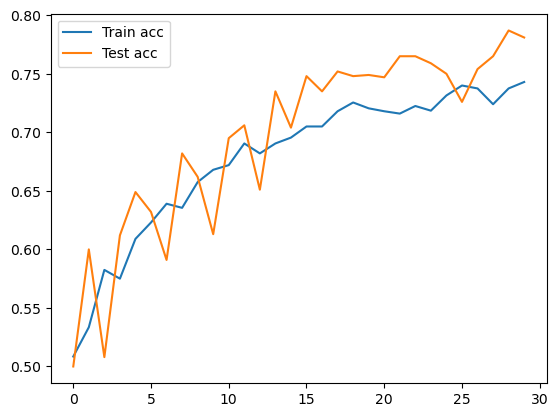

In [97]:
plt.plot(epochs, acc, label='Train acc')
plt.plot(epochs, val_acc, label='Test acc')
plt.legend()

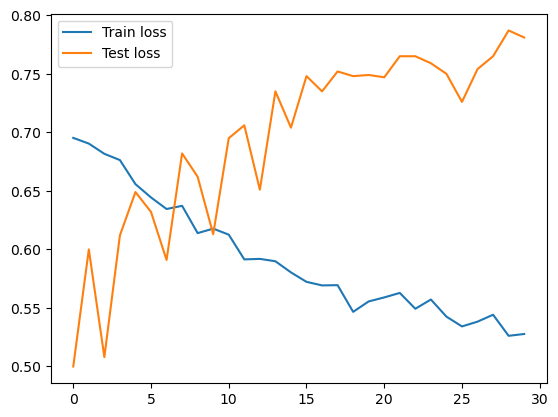

In [98]:
plt.plot(epochs, loss, label='Train loss')
plt.plot(epochs, val_loss, label='Test loss')
plt.legend()